In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ['GROQ_API_KEY'] = os.getenv("groq_api_key")
os.environ['LANGSMITH_API_KEY'] = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "default1"
type(os.environ['GROQ_API_KEY'])

str

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict


In [3]:
from langgraph.graph import StateGraph, add_messages, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langchain_core.tools import tool

from langchain.chat_models import init_chat_model

In [4]:
class State(TypedDict):
    messages : Annotated[list, add_messages]

llm = init_chat_model(model= "groq:llama-3.1-8b-instant")

@tool
def add_number1(a:int, b:int)->int:
    """ add given numbers"""
    return (a+b) 

tools = [add_number1]

llm_tool = llm.bind_tools(tools)

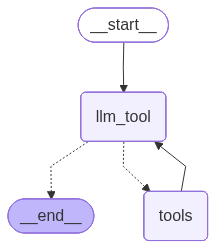

In [5]:
graph_builder = StateGraph(State)

def chatbot(state:State):
    return {"messages": llm_tool.invoke(state['messages'])}

#add nodes
graph_builder.add_node('llm_tool', chatbot)
graph_builder.add_node('tools', ToolNode(tools))

# add adges
graph_builder.add_edge(START, 'llm_tool')

graph_builder.add_conditional_edges('llm_tool', tools_condition)
graph_builder.add_edge('tools', 'llm_tool')

graph= graph_builder.compile()
graph


In [6]:
response = graph.invoke({"messages": "what is 30 plus 40"})

In [7]:
response

{'messages': [HumanMessage(content='what is 30 plus 40', additional_kwargs={}, response_metadata={}, id='8ba13b27-ffac-41b2-a4b0-6e0b36e528d6'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'x1hcfbd2t', 'function': {'arguments': '{"a":30,"b":40}', 'name': 'add_number1'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 223, 'total_tokens': 243, 'completion_time': 0.028245155, 'completion_tokens_details': None, 'prompt_time': 0.017758076, 'prompt_tokens_details': None, 'queue_time': 0.087781852, 'total_time': 0.046003231}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c76e6-5f62-7a80-8af5-6fae84431d1e-0', tool_calls=[{'name': 'add_number1', 'args': {'a': 30, 'b': 40}, 'id': 'x1hcfbd2t', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 223, 